In [5]:
import pandas as pd
import re

from simulation_utils import get_data_by_year

def build_data_by_year(year):
    df = pd.DataFrame(get_data_by_year(year)["matches"])

    # Drop columns we don"t need
    df = df[["utcDate", "matchday", "homeTeam", "awayTeam", "score"]]

    # Parse the homeTeam and awayTeam and get the names or ids from the column
    df["home"] = df["homeTeam"].apply(lambda x: x["name"])
    df["away"] = df["awayTeam"].apply(lambda x: x["name"])
    df = df.drop(columns=["homeTeam", "awayTeam"])

    # Get home team and away team scores from the dataframe, drop score column
    df["homeScore"] = df["score"].apply(lambda x: x["fullTime"]["home"])
    df["awayScore"] = df["score"].apply(lambda x: x["fullTime"]["away"])
    df = df.drop(columns=["score"])

    # Convert utcDate to datetime
    df["utcDate"] = pd.to_datetime(df["utcDate"])

    # Function to convert camel case to title case
    def camel_to_title(camel_str):
        title_str = re.sub("([A-Z])", r" \1", camel_str)
        return title_str.title()

    # Apply the function to each column name
    df.columns = [camel_to_title(col) for col in df.columns]

    return df

# Get data for 2022-2023 season
df = build_data_by_year(2022)

# Get data for the 2023-2024 season
df_2023 = build_data_by_year(2023)

## Setting up Training Data

In [6]:
from simulation_utils import process_fixture_results

# Process the fixture results for the 2022-2023 season and the 2023-2024 season
df, results = process_fixture_results(df)
df_2023, results_2023 = process_fixture_results(df_2023)

results

,Home Outcome,Home Elo,Away Outcome,Away Elo,Total Outcome,Total Elo
Team,,,,,,
Manchester City FC,52,1833.153506,37,1791.740993,89,3624.894499
Arsenal FC,45,1713.494293,39,1702.998021,84,3416.492314
Manchester United FC,48,1696.854889,27,1672.974926,75,3369.829815
Newcastle United FC,39,1689.191732,32,1678.969490,71,3368.161221
Liverpool FC,44,1704.750654,23,1689.842154,67,3394.592808
Brighton & Hove Albion FC,34,1633.759996,28,1614.429813,62,3248.189809
Aston Villa FC,38,1664.730431,23,1645.400247,61,3310.130678
Tottenham Hotspur FC,37,1562.932582,23,1575.570725,60,3138.503307
Brentford FC,37,1647.897784,22,1617.297523,59,3265.195307


### Analyze Elo vs Outcome for Real Results

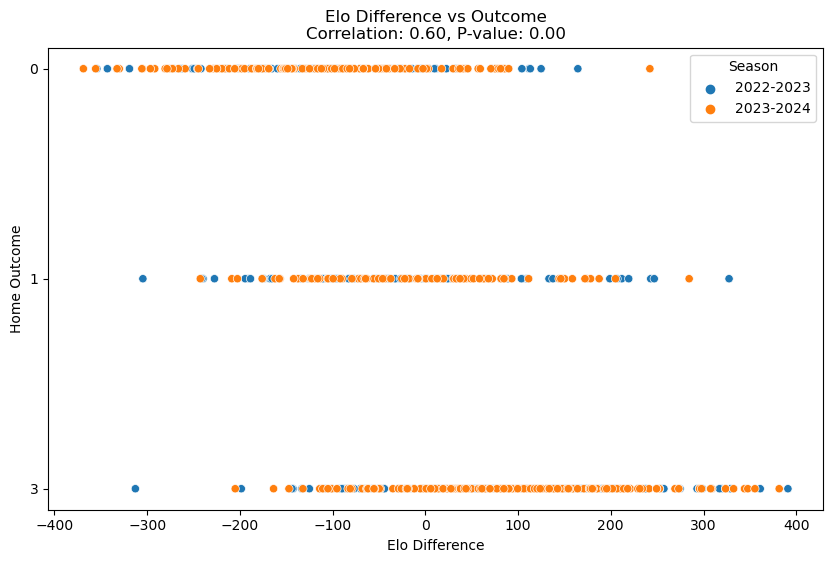

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Calculate Elo vs Outcome correlation
data_2022 = df[["Home Elo", "Away Elo", "Home Outcome"]].copy()
data_2022["Season"] = "2022-2023"
data_2023 = df_2023[["Home Elo", "Away Elo", "Home Outcome"]].copy()
data_2023["Season"] = "2023-2024"
data_2022_2024 = pd.concat([data_2022, data_2023])

data_2022_2024["Elo Difference"] = data_2022_2024["Home Elo"] - data_2022_2024["Away Elo"]

# Convert 'Home Outcome' to categorical type with specified categories
data_2022_2024['Home Outcome'] = pd.Categorical(data_2022_2024['Home Outcome'], categories=[3, 1, 0], ordered=True)

# Calculate correlation
correlation, p_value = pearsonr(data_2022_2024["Elo Difference"], data_2022_2024["Home Outcome"])

# Convert 'Home Outcome' to string type
data_2022_2024['Home Outcome'] = data_2022_2024['Home Outcome'].astype(str)

plt.figure(figsize=(10, 6))

# Visualization
sns.scatterplot(data=data_2022_2024, x="Elo Difference", y="Home Outcome", hue="Season")
plt.title(f"Elo Difference vs Outcome\nCorrelation: {correlation:.2f}, P-value: {p_value:.2f}")
plt.show()

## Training

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For simplicity, let"s predict the home outcome based on Elo ratings
x = df[["Home Elo", "Away Elo"]]
y = df["Home Outcome"]

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

# Standardize the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

# Train the model
model = RandomForestClassifier(n_estimators=1000, max_depth=5, min_samples_split=5)
model.fit(x_train, y_train)

# Validate the model
val_score = model.score(x_val, y_val)
print(f"Validation accuracy: {val_score * 100:.2f}%")

Validation accuracy: 67.11%


### Build Elo

In [13]:
from simulation_utils import build_elo_df_from_dict

# Find teams that have been relegated/promoted by taking a difference of the two dataframes
df_teams = pd.concat([df["Home"], df["Away"]]).unique()
df_2023_teams = pd.concat([df_2023["Home"], df_2023["Away"]]).unique()

relegated_teams = set(df_teams) - set(df_2023_teams)
promoted_teams = set(df_2023_teams) - set(df_teams)
teams_with_baseline = set(df_teams) & set(df_2023_teams)

# Find the average ending ELO rating for the teams that have been relegated
relegated_elo = results.loc[list(relegated_teams), "Total Elo"].max()

# Set the starting ELO rating for the promoted teams to the average ending ELO rating of the relegated teams
elo = {team: relegated_elo for team in promoted_teams}

# Set the starting ELO rating for the teams that have been in the league for both seasons to their ending ELO rating
elo.update(results.loc[list(teams_with_baseline), "Total Elo"].to_dict())

# Divide Elo by 2
elo = {team: elo[team] / 2 for team in elo}

elo_df = build_elo_df_from_dict(elo)
elo_df

,Elo,Club Value,Normalized Club Value,Adjusted Elo
Team,,,,
Burnley FC,1454.993848,2.574300e+08,0.117797,1466.773499
Luton Town FC,1454.993848,1.155500e+08,0.000000,1454.993848
Sheffield United FC,1454.993848,1.220000e+08,0.005355,1455.529362
Newcastle United FC,1684.080611,6.489500e+08,0.442858,1728.366384
Nottingham Forest FC,1505.600649,3.872500e+08,0.225580,1528.158663
Brighton & Hove Albion FC,1624.094905,5.117500e+08,0.328947,1656.989587
Wolverhampton Wanderers FC,1518.213148,3.498000e+08,0.194487,1537.661859
Fulham FC,1548.552484,3.243000e+08,0.173316,1565.884046
Manchester City FC,1812.447249,1.320000e+09,1.000000,1912.447249


## Test Against 2023-2024 Season

### Predict 2023-2024 Season

In [14]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

from simulation_utils import simulate_and_get_results

# Get adjusted Elo dict
adjusted_elo = elo_df["Adjusted Elo"].to_dict()

# Number of simulations to run
num_simulations = 50

# Initialize a list to store results
seasons = []

# Initialize a pool of workers
with ProcessPoolExecutor() as executor:
    seasons = list(tqdm(executor.map(simulate_and_get_results, range(num_simulations), [df_2023]*num_simulations, [adjusted_elo]*num_simulations, [model]*num_simulations, [scaler]*num_simulations),  total=num_simulations, desc='Simulating', unit='season'))

Simulating: 100%|██████████| 50/50 [01:48<00:00,  2.17s/season]


### Analyze Results Compared to actual 2023-2024 Season

### Post Process Simulation Results

In [15]:
# Sort results based on total outcome
results = results.sort_values("Total Outcome", ascending=False)

# Get the place each team finished in the league
results["Place"] = range(1, len(results) + 1)

# Get 2023 season results
# Determine outcomes: 3 for win, 1 for draw, 0 for loss
df_2023["Home Outcome"] = 1
df_2023["Away Outcome"] = 1
df_2023.loc[df_2023["Home Score"] > df_2023["Away Score"], "Home Outcome"] = 3
df_2023.loc[df_2023["Home Score"] > df_2023["Away Score"], "Away Outcome"] = 0
df_2023.loc[df_2023["Away Score"] > df_2023["Home Score"], "Away Outcome"] = 3
df_2023.loc[df_2023["Away Score"] > df_2023["Home Score"], "Home Outcome"] = 0

home_results = df_2023.groupby("Home").agg({"Home Outcome": "sum"})
away_results = df_2023.groupby("Away").agg({"Away Outcome": "sum"})
results_2023 = home_results.join(away_results, how="outer").fillna(0)
results_2023["Total Outcome"] = results_2023["Home Outcome"] + results_2023["Away Outcome"]
results_2023 = results_2023.sort_values("Total Outcome", ascending=False)
results_2023["Place"] = range(1, len(results_2023) + 1)

# For each season, get the place each team finished in the league
for index, season_df in enumerate(seasons):
    season_df["Place"] = range(1, len(season_df) + 1)

# Get the average place each team finished in the league
average_results = pd.concat(seasons).groupby("Team").agg({"Place": "mean"}).sort_values("Place")

# Get a mapping of team names to a list places they finished in the league
team_place_mapping = {}
for team in average_results.index:
    team_place_mapping[team] = [season_df.loc[team, "Place"] for season_df in seasons]

# Get the total number of seasons simulated
total_seasons = len(seasons)

# Get a mapping of times each team won the league
team_win_mapping = {}
for team in average_results.index:
    team_win_mapping[team] = sum([season_df.loc[team, "Place"] == 1 for season_df in seasons]) / total_seasons

# Get a mapping of times each team finished in the top 4
team_top_4_mapping = {}
for team in average_results.index:
    team_top_4_mapping[team] = sum([season_df.loc[team, "Place"] <= 4 for season_df in seasons]) / total_seasons

# Get a mapping of times each team finished in the bottom 3
team_bottom_3_mapping = {}
for team in average_results.index:
    team_bottom_3_mapping[team] = sum([season_df.loc[team, "Place"] >= len(season_df) - 3 for season_df in seasons]) / total_seasons

# Build a dataframe with the average place, times won, times in top 4, and times in bottom 3
average_results["Win Premier League"] = [team_win_mapping[team] for team in average_results.index]
average_results["Top 4"] = [team_top_4_mapping[team] for team in average_results.index]
average_results["Bottom 3"] = [team_bottom_3_mapping[team] for team in average_results.index]

# Show the dataframe
average_results

,Place,Win Premier League,Top 4,Bottom 3
Team,,,,
Arsenal FC,3.04,0.28,0.82,0.00
Liverpool FC,3.06,0.22,0.86,0.00
Manchester City FC,3.28,0.26,0.72,0.00
Manchester United FC,4.02,0.10,0.58,0.00
Newcastle United FC,5.22,0.06,0.40,0.00
Aston Villa FC,6.18,0.02,0.24,0.00
Brighton & Hove Albion FC,6.76,0.02,0.16,0.00
Brentford FC,7.42,0.02,0.12,0.00
Tottenham Hotspur FC,8.80,0.02,0.06,0.00
